<a href="https://colab.research.google.com/github/nahumsa/Variational-Autoencoder/blob/master/VAE%20Entanglement%20Witness%20Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating entangled and separable states with qutip

## Installing dependencies

In [1]:
!git clone https://github.com/nahumsa/Variational-Autoencoder.git

Cloning into 'Variational-Autoencoder'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 121 (delta 53), reused 80 (delta 26), pack-reused 0
Receiving objects: 100% (121/121), 28.37 MiB | 4.38 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 3.5MB 33.1MB/s 
  Created wheel for qutip: filename=qutip-4.5.0-cp36-cp36m-linux_x86_64.whl size=12885024 sha256=cfe4384947f2c4cc92061569a55cc2056c5104656402361890cc836f6db168a2
  Stored in directory: /root/.cache/pip/wheels/c9/85/e8/3fbad9a0816141b4c5f1d73d8a880ed91265fea84192cbe37b
Successfully built qutip


In [3]:
% cd Variational-Autoencoder/

/content/Variational-Autoencoder


## Creating the dataset

We want to take the partial transpose of the density matrix and check if it $\rho > 0$. [link](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion)

Here we are following the Perez-Horondecki criterion, if the partial transpose of the density matrix is negative, the state has to be entangled. 

Because it the state is separable, it will be positive definite by definition.

In [4]:
try:
  %tensorflow_version 1.x

except Exception:
  pass
  
import tensorflow as tf
#Set Random Seed for reproduction
tf.compat.v1.set_random_seed(1234)

import warnings
warnings.filterwarnings("ignore")

TensorFlow 1.x selected.


In [0]:
from itertools import product
import qutip as qutip
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def measurement(density_matrix, base, name_base):
  """Measuring the quantum state on a given basis.
  """
  _measurements_names = []
  _measurements = []

  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_base, base),zip(name_base, base)):
    #Ignore the II measurement because it is always 1
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      measurement_op = qutip.tensor(meas_1,meas_2)
      _measurements.append(qutip.expect(measurement_op, density_matrix))
      _measurements_names.append(name_1 + name_2)

  return [i for i in zip(_measurements, _measurements_names)]

def create_density_matrix(base,name_base):
  """ Create a random density matrix."""

  for (name_1, basis_1),(name_2, basis_2) in product(zip(name_base, base),zip(name_base, base)):
    if name_1 == 'I' and name_2 == 'I':
      density_matrix = 0.25*qutip.tensor(basis_1, basis_2)
    else: 
      density_matrix += 0.25*np.random.rand()*qutip.tensor(basis_1,basis_2)
  
  return density_matrix

def create_dataset(n_samples):
  
  _states = []
  _labels = []
  _measurements = []

  #Basis Measured
  name_basis = ['I', 'X', 'Y', 'Z']
  basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]



  for _ in range(n_samples):    
    density = qutip.rand_dm(4, density=0.75, dims=[[2,2],[2,2]])
    
    #Partial Transpose
    density_partial_T = qutip.partial_transpose(density, [0,1])    
  
    #Labels: 1 if entangled -1 if separable (PPT Criterion)
    if (density_partial_T.eigenenergies() < 0).any():
      _labels.append(1)
  
    else:      
      _labels.append(0)
      #_labels.append(-1)  

    _states.append(density)  
  
    val_measurements = measurement(density_matrix=density, 
                                   base=basis, 
                                   name_base=name_basis)
  
    _measurements.append(val_measurements)
    
  return _states, _measurements, _labels

In [0]:
samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

Checking the distribution of the labels.

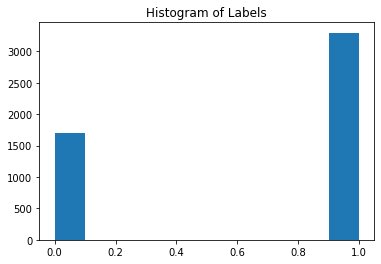

In [90]:
plt.hist(labels_train)
plt.title('Histogram of Labels')
plt.show()

In [0]:
#Unpacking the training data
def create_x(measurement):
  """Create an list with measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result ,_ in meas:
      aux.append(result)
    X.append(aux)
  return X

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)
#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)
#transform into categories
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

In [95]:
print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y:(5000, 2)


# Build a Variational Autoencoder

In [0]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from keras.models import Model
#from Models.VAE_Keras import DenseVariationalAutoencoderKeras
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (15,)
encoder_dense = [512,256]
decoder_dense = [256, 512, 2]
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = False
                                        , use_dropout= False
                                        )

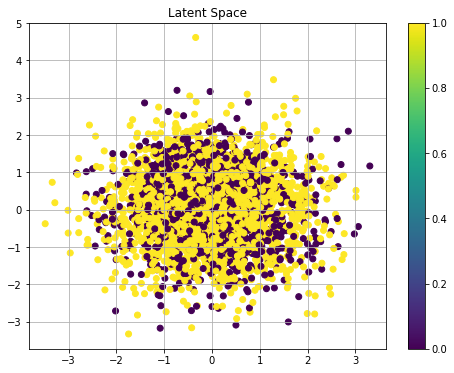

In [99]:
z_mu = bvae.encoder.predict(X_test)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=Y_test)
plt.colorbar()
plt.title(f'Latent Space')
plt.grid()

In [100]:
bvae.decoder.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape_9 (Reshape)          (None, 256)               0         
_________________________________________________________________
decoder_dense_0 (Dense)      (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 512)               0  

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 10
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [0]:
# Training Parameters

BATCH_SIZE = 256

EPOCHS = 100

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 0

In [0]:
history = bvae.train(     
                      x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH
                    )

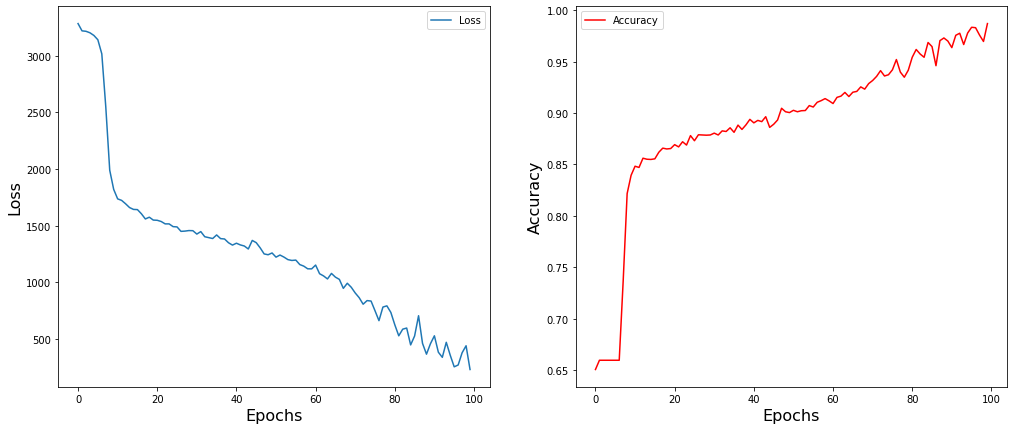

In [104]:
loss = history.history['loss']
epochs = range(len(loss))

accuracy = history.history['acc']
epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

ax1.plot(epochs, loss, label='Loss')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Accuracy')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

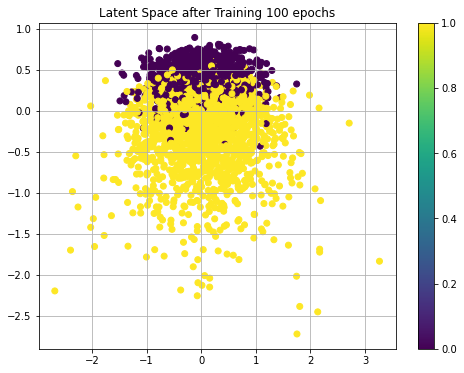

In [105]:
z_mu = bvae.encoder.predict(X_test)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=Y_test)
plt.colorbar()
plt.title(f'Latent Space after Training {EPOCHS} epochs')
plt.grid()